Model from repo:

https://github.com/lucidrains/bidirectional-cross-attention

# Adapt function to work with our data

We will use:
> For peptide the csv file with the peptide sequences, hla, and label

> For HLA the raw data with the hla fingerprints

In [92]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch import einsum
import torchmetrics
from einops import rearrange, repeat
from einops.layers.torch import Rearrange, Reduce
import numpy as np
import pandas as pd
import os
import math
import logging
from logavgexp_pytorch import logavgexp
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve
from bidirectional_cross_attention import BidirectionalCrossAttention


In [2]:
def balance_data(data: np.array or pd.DataFrame,
                 binary_labels: np.array or pd.Series, 
                 random_seed: int = 42):
    """
    Balance data by getting reducing the number of samples of the
     majority class to the number of samples of the minority class
    """
    np.random.seed(random_seed)
    # Balance data
    pos_idx = np.where(binary_labels == 1)[0]
    neg_idx = np.where(binary_labels == 0)[0]
    
    n_pos = len(pos_idx)
    n_neg = len(neg_idx)
    
    n_samples = min(n_pos, n_neg)
    
    print(f"There are {n_pos} positive samples and {n_neg} negative samples. "
          f"We will balance the data to {n_samples} samples per class.")
    
    pos_idx = np.random.choice(pos_idx, n_samples, replace=False)
    neg_idx = np.random.choice(neg_idx, n_samples, replace=False)
    
    if type(data) == pd.DataFrame:
        balanced_data = pd.concat([data.iloc[pos_idx], data.iloc[neg_idx]])
    elif type(data) == np.array:
        balanced_data = np.concatenate([data[pos_idx], data[neg_idx]])
    else:
        raise TypeError("Data must be a pandas DataFrame or a numpy array")
    
    if type(binary_labels) == pd.Series:
        balanced_labels = pd.concat([binary_labels.iloc[pos_idx], binary_labels.iloc[neg_idx]])
    elif type(binary_labels) == np.array:
        balanced_labels = np.concatenate([binary_labels[pos_idx], binary_labels[neg_idx]])
    else:
        raise TypeError("Data must be a pandas Series or a numpy array")
    
    assert len(balanced_data) == len(balanced_labels), "Data and labels do not have the same length. Check the code."
    
    return balanced_data, balanced_labels

In [3]:
MAX_PEPTIDE_LEN = 15
BALANCE_DATA = True
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DATA_FOLDER = os.path.join('..', 'data')
PROCESS_DATA_FOLDER = os.path.join(DATA_FOLDER, 'processed')
PROCESS_pHLA_BINDING_DATA_FOLDER = os.path.join(PROCESS_DATA_FOLDER, 'pHLA_binding')
PROCESS_pHLA_BINDING_NetMHDpan_FOLDER = os.path.join(PROCESS_pHLA_BINDING_DATA_FOLDER, 'NetMHCpan_dataset')
PROCESS_HLA_FP_FOLDER = os.path.join(PROCESS_DATA_FOLDER, 'hla_fingerprints')

# Just using MonoAllelicData
train_peptide_ba_data_file = os.path.join(PROCESS_pHLA_BINDING_NetMHDpan_FOLDER, 'train_binding_affinity_peptides_data_MaxLenPep15_hla_ABC.csv')
train_peptide_el_data_file = os.path.join(PROCESS_pHLA_BINDING_NetMHDpan_FOLDER, 'train_eluted_ligand_peptides_data_mono_MaxLenPep15_hla_ABC.csv.gz')
test_peptide_data_file = os.path.join(PROCESS_pHLA_BINDING_NetMHDpan_FOLDER, 'test_set_peptides_data_MaxLenPep15_hla_ABC.csv.gz')
hla_fp_data_file = os.path.join(PROCESS_HLA_FP_FOLDER, 'hla_fingerprint_netMHCpan_pseudoseq_res_representation.npy')
hla_info_file = os.path.join(PROCESS_HLA_FP_FOLDER, 'hla_index_netMHCpan_pseudoseq_res_representation.csv')

In [4]:
hla_data = np.load(hla_fp_data_file)
hla_info = pd.read_csv(hla_info_file, index_col=0)
# make a dict with hla names and their fingerprints using index
hla_fp_dict = {hla_info.loc[i, 'hla_allele']: hla_data[i] for i in range(hla_data.shape[0])}

In [5]:
# Make a list of HLA and a list of peptide sequences
train_peptide_ba_data = pd.read_csv(train_peptide_ba_data_file)
# train_peptide_el_data = pd.read_csv(train_peptide_el_data_file)
test_peptide_data = pd.read_csv(test_peptide_data_file)

if BALANCE_DATA:
    train_peptide_ba_data, _ = balance_data(train_peptide_ba_data, train_peptide_ba_data.label)
    # train_peptide_el_data, _ = balance_data(train_peptide_el_data, train_peptide_el_data.label)
    test_peptide_data, _ = balance_data(test_peptide_data, test_peptide_data.label)

There are 42001 positive samples and 128106 negative samples. We will balance the data to 42001 samples per class.
There are 1660 positive samples and 11770570 negative samples. We will balance the data to 1660 samples per class.


In [6]:
train_hla_ba = train_peptide_ba_data.hla_allele.to_numpy()
train_peptide_ba = train_peptide_ba_data.peptide.to_numpy()
train_labels_ba = train_peptide_ba_data.label.to_numpy()

# train_hla_el = train_peptide_el_data.hla_allele.to_numpy()
# train_peptide_el = train_peptide_el_data.peptide.to_numpy()
# train_labels_el = train_peptide_el_data.label.to_numpy()

test_hla = test_peptide_data.hla_allele.to_numpy()
test_peptide = test_peptide_data.peptide.to_numpy()
test_labels = test_peptide_data.label.to_numpy()

In [7]:
class SeqTokenizer:
    def __init__(self):
        padding_chr = 'X'
        alphabet = padding_chr + 'ACDEFGHIKLMNPQRSTVWY' 
        self.alphabet = alphabet
        self.padding_chr = padding_chr
        self.padding_idx = alphabet.index(padding_chr)
        self.char2idx = {char: i for i, char in enumerate(alphabet)}
        self.idx2char = {i: char for i, char in enumerate(alphabet)}
    
    def tokenize(self, seq):
        return [self.char2idx[char] for char in seq]
    
    def detokenize(self, tokens):
        return ''.join([self.idx2char[i] for i in tokens])
    
    def __len__(self):
        return len(self.alphabet)

class pHLAData(torch.utils.data.Dataset):
    def __init__(self, peptide_seq_arr, hla_names_arr, hla_fp_dict, labels, pep_tokenizer, max_peptide_len=15):
        # Validate inputs
        assert len(peptide_seq_arr) == len(hla_names_arr) == len(labels),\
            'Peptide, HLA and labels must have the same length'
        assert type(peptide_seq_arr) == np.ndarray, 'peptide_seq_arr must be a numpy array'
        assert type(hla_names_arr) == np.ndarray, 'hla_names_arr must be a numpy array'
        assert type(labels) == np.ndarray, 'labels must be a numpy array'
        hla_keys = set(list(hla_fp_dict))
        unique_hla_list = set(hla_names_arr)
        if not unique_hla_list.issubset(hla_keys):
            err_msg = (f"hla_fp_dict does not have all the hla_names."
                       f" Missing HLAs: {unique_hla_list - hla_keys}")
            raise KeyError(err_msg)
        
        peptide_pad = [pep + 'X'*(max_peptide_len-len(pep)) for pep in peptide_seq_arr]
        peptide_idx_list = [torch.Tensor(pep_tokenizer.tokenize(pep)).long() for pep in peptide_pad]
        self.peptides = peptide_idx_list
        hlas_fp_list = [torch.Tensor(hla_fp_dict[hla]) for hla in hla_names_arr]
        self.hlas = hlas_fp_list # In the same order as peptide
        # one hot encoding of labels
        N_LABELS = 2 # binary classification
        labels = np.eye(N_LABELS)[labels]
        self.labels = torch.Tensor(labels)
    
    def __len__(self):
        return len(self.hlas)
    
    def __getitem__(self, idx):
        hla_fp = self.hlas[idx]
        peptide_idx = self.peptides[idx]
        label = self.labels[idx]
        return peptide_idx, hla_fp, label 
    

In [8]:
# tensor helpers
def l2norm(t):
    return F.normalize(t, dim = -1)

def prob_mask_like(t, prob):
    return torch.zeros_like(t).float().uniform_(0, 1) < prob

def fourier_encode(x, dims, theta = 20000):
    device, dtype = x.device, x.dtype
    emb = math.log(theta) / (dims // 2)
    emb = torch.exp(torch.arange(dims // 2, device = device) * -emb)
    emb = rearrange(x, 'n -> n 1') * rearrange(emb, 'd -> 1 d')
    emb = torch.cat((emb.sin(), emb.cos()), dim = -1)
    return emb

def exists(val):
    return val is not None

def default(val, d):
    return val if exists(val) else d

def FeedForward(dim, mult = 4, dropout = 0.):
    return nn.Sequential(
        nn.LayerNorm(dim),
        nn.Linear(dim, dim * mult),
        nn.GELU(),
        nn.Dropout(dropout),
        nn.Linear(dim * mult, dim)
    )

# read value MLP for calculating auxiliary loss
class ReadValueMLP(nn.Module):
    def __init__(
        self,
        dim,
        *,
        fourier_dims = 256,
        norm_factor_fourier = 50,
        norm_factor_linear = 8000,
        eps = 1e-20
    ):
        super().__init__()
        self.eps = eps
        self.fourier_dims = fourier_dims
        self.norm_factor_fourier = norm_factor_fourier
        self.norm_factor_linear = norm_factor_linear

        self.logits_norm = nn.Sequential(
            Reduce('b n d -> b d', 'mean'),
            nn.LayerNorm(dim)
        )

        self.mlp = nn.Sequential(
            nn.Linear(dim + fourier_dims + 2, dim * 2),
            nn.GELU(),
            nn.Linear(dim * 2, 1),
            Rearrange('... 1 -> ...')
        )

    def forward(self, logits, peaks_nr, read_value):
        logits = self.logits_norm(logits)

        peaks_nr_log_space = torch.log(peaks_nr + self.eps)

        peaks_nr = rearrange(peaks_nr, '... -> (...)')
        peaks_nr_encoded = fourier_encode(peaks_nr / self.norm_factor_fourier, self.fourier_dims)
        peaks_nr_normed = rearrange(peaks_nr, '... -> ... 1') / self.norm_factor_linear

        peaks_nr_encoded_with_self = torch.cat((peaks_nr_normed, peaks_nr_log_space, peaks_nr_encoded), dim = -1)

        logits_with_peaks = torch.cat((logits, peaks_nr_encoded_with_self), dim = -1)

        pred = self.mlp(logits_with_peaks)
        read_value = rearrange(read_value, '... -> (...)')

        return F.smooth_l1_loss(pred, read_value)

class HypergridLinear(nn.Module):
    def __init__(
        self,
        dim,
        dim_out,
        *,
        context_dim
    ):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(dim, dim_out))
        self.contextual_projection = nn.Linear(context_dim, dim * dim_out)

    def forward(self, x, context):
        # derive contextual gating, from hypergrids paper

        gating = self.contextual_projection(context).sigmoid()
        gating = rearrange(gating, 'b (i o) -> b i o', i = int(math.sqrt(gating.shape[-1])))

        # gate interactions projection with context

        to_logits_w = rearrange(self.weights, 'i o -> 1 i o') * gating
        return einsum('b n d, b d e -> b n e', x, to_logits_w)


class FILIP(nn.Module):
    def __init__(
        self,
        dim,
        context_dim,
        heads,
        dim_head = 64,
        dropout = 0.
    ):
        super().__init__()
        self.heads = heads
        inner_latent_dim = heads * dim_head

        self.to_latent_w = nn.Parameter(torch.randn(dim, inner_latent_dim))
        self.to_latent_b = nn.Parameter(torch.randn(inner_latent_dim))

        self.pre_attn_dropout = dropout

        self.null_context = nn.Parameter(torch.randn(heads, dim_head))
        self.context_to_latent_w = nn.Parameter(torch.randn(context_dim, inner_latent_dim))
        self.context_to_latent_b = nn.Parameter(torch.randn(inner_latent_dim))

    def forward(
        self,
        x,
        context,
        context_mask = None
    ):
        b, heads, device = x.shape[0], self.heads, x.device

        x = einsum('b n d, d e -> b n e', x, self.to_latent_w)
        x = x + self.to_latent_b

        x = rearrange(x, 'b n (h d) -> b h n d', h = heads)

        context = einsum('b n d, d e -> b n e', context, self.context_to_latent_w)
        context = context + self.context_to_latent_b

        context = rearrange(context, 'b n (h d) -> b h n d', h = heads)

        context, x = map(l2norm, (context, x))

        # fine grained interaction between dna and protein sequences
        # FILIP https://arxiv.org/abs/2111.07783

        if x.shape[0] == 1:
            # in the case one passes in 1 genomic sequence track
            # but multiple factors + contexts, as in enformer training
            x = rearrange(x, '1 ... -> ...')
            einsum_eq = 'h i d, b h j d -> b h i j'
        else:
            einsum_eq = 'b h i d, b h j d -> b h i j'

        # create context mask if not exist

        if not exists(context_mask):
            context_mask = torch.ones((b, context.shape[-1]), device = device).bool()

        # dropout mask by dropout prob

        if self.training:
            keep_mask = prob_mask_like(context_mask, 1 - self.pre_attn_dropout)
            context_mask = context_mask & keep_mask

        # add null context and modify mask

        context_mask = F.pad(context_mask, (1, 0), value = True)
        context_mask = rearrange(context_mask, 'b j -> b 1 1 j')

        null_context = repeat(self.null_context, 'h d -> b h 1 d', b = b)
        context = torch.cat((null_context, context), dim = -2)

        # differentiable max, as in FILIP paper

        interactions = einsum(einsum_eq, x, context)
        interactions = logavgexp(interactions, mask = context_mask, dim = -1, temp = 0.05)
        interactions = rearrange(interactions, 'b h i -> b i h')
        return interactions
    


In [9]:
class PepHLAJointCrossAttentionBlock(nn.Module):
    def __init__(self,
                 p_emb_dim=10,  # Number of features for each residue after the embedding
                 hla_fp_dim=80, # Number of features for each residue fingerprint 
                 heads = 4,     # Num heads in Bidirectional Cross Attention
                 dim_head = 64, # Dim of each head in Bidirectional Cross Attention
                 ff_mult = 4,   # Dim multiplier in FeedForward after Bidirectional Cross Attention
                 dropout = 0.):
        """
        Higly inspired on JointCrossAttentionBlock from the repo:
            https://github.com/lucidrains/tf-bind-transformer
        """
        super(PepHLAJointCrossAttentionBlock, self).__init__()
        self.joint_cross_attn = BidirectionalCrossAttention(
            dim = p_emb_dim,
            heads = heads,
            dim_head = dim_head,
            context_dim = hla_fp_dim
        )
        self.peptide_ff = FeedForward(p_emb_dim, mult = ff_mult, dropout = dropout)
        self.hla_fp_ff = FeedForward(hla_fp_dim, mult = ff_mult, dropout = dropout)
        
    
    def forward(self, pep_emb, hla_fp, peptide_mask, hla_fp_mask, return_attn = False):
        cross_att_out = self.joint_cross_attn(
            pep_emb,
            hla_fp,
            mask = peptide_mask,
            context_mask = hla_fp_mask,
            return_attn = return_attn
        )
        if return_attn:
            pep_out, hla_out, pep_attn_out, hla_fp_attn_out = cross_att_out
        else:
            pep_out, hla_out = cross_att_out
        pep_emb = pep_emb + pep_out
        hla_fp = hla_fp + hla_out
        
        pep_emb = self.peptide_ff(pep_emb) + pep_emb
        hla_fp = self.hla_fp_ff(hla_fp) + hla_fp
        
        return pep_emb, hla_fp

In [44]:
class pHLAPredictor(nn.Module):
    def __init__(self,
                 p_emb_dim=10,  # Number of features for each residue after the embedding
                 hla_fp_dim=80, # Number of features for each residue fingerprint 
                 joint_cross_attn_depth=1, # Number of JointCrossAttention blocks
                 heads = 4,     # Num heads in Bidirectional Cross Attention
                 dim_head = 64, # Dim of each head in Bidirectional Cross Attention
                 ff_mult = 4,   # Dim multiplier in FeedForward after Bidirectional Cross Attention
                 latent_heads = 4, # Num heads in FILIP
                 latent_dim = 64,  # Dim of each head in FILIP
                 condition_hypergrid = False, # If True, use HypergridLinear to condition the logits
                 target_mse_loss = False, # If True, use MSE loss for the target
                 fourier_dims = 256, # Dim of the Fourier encoding
                 dropout = 0.,
                 padding_idx_seq = 0):
        """
        Highly inspired on AdapterModel from the repo:
            https://github.com/lucidrains/tf-bind-transformer
        """
        super(pHLAPredictor, self).__init__()
        self.peptide_embedding = nn.Embedding(21, p_emb_dim, padding_idx=padding_idx_seq) # 20 AAs + 1 for padding
        # joint attn
        self.joint_cross_attns = nn.ModuleList([])
        for _ in range(joint_cross_attn_depth):
            attn = PepHLAJointCrossAttentionBlock(
                        p_emb_dim=p_emb_dim,
                        hla_fp_dim=hla_fp_dim,
                        heads=heads,
                        dim_head=dim_head,
                        ff_mult=ff_mult,
                        dropout=dropout)
            self.joint_cross_attns.append(attn)

        # latent space
        self.filip = FILIP(
            dim = p_emb_dim,
            context_dim = hla_fp_dim,
            heads = latent_heads,
            dim_head = latent_dim,
            dropout = dropout
        )
        
        # hypergrid conditioning
        if condition_hypergrid:
            self.linear_with_hypergrid = HypergridLinear(latent_heads, latent_heads, context_dim = hla_fp_dim)
        else:
            self.linear_to_logits = nn.Linear(latent_heads, latent_heads)
            self.linear_with_hypergrid = None
            
        
        # Pred binary label
            Rearrange('... 1 -> ...')
        self.to_pred = nn.Sequential(
            Reduce('... n d -> ... d', 'mean'),
            nn.LayerNorm(latent_heads),
            # nn.Linear(latent_heads, 1),
            # Rearrange('... 1 -> ...')
            nn.Linear(latent_heads, 2), # 2 classes
        )

        self.to_read_value_aux_loss = ReadValueMLP(
            dim = latent_heads,
            fourier_dims = fourier_dims
        )
        
    
    def forward(self, pep_seq_idx, hla_fp, peptide_mask, hla_fp_mask, return_attn = False):
        pep_emb = self.peptide_embedding(pep_seq_idx)
        for cross_attn in self.joint_cross_attns:
            pep_emb, hla_fp = cross_attn(
                pep_emb,
                hla_fp,
                peptide_mask = peptide_mask,
                hla_fp_mask = hla_fp_mask,
                return_attn = return_attn
            )        
        # project both embeddings into shared latent space
        interactions = self.filip(
            pep_emb,
            hla_fp,
            context_mask = hla_fp_mask
        )

        if exists(self.linear_with_hypergrid):
            logits = self.linear_with_hypergrid(interactions, context = hla_fp_dim)
        else:
            logits = self.linear_to_logits(interactions)
        pred = self.to_pred(logits)
        pred = F.softmax(pred, dim=-1)
        return pred

Testing it runs

In [29]:
# TODO Join BA and EL data to train data
# TODO transform labels to one-hot encoding ?
seq_tokenizer = SeqTokenizer()

train_data = pHLAData(train_peptide_ba, train_hla_ba, hla_fp_dict, train_labels_ba, seq_tokenizer, max_peptide_len=MAX_PEPTIDE_LEN)

# test_data = pHLAData(test_peptide, test_hla, hla_fp_dict, test_labels, seq_tokenizer, max_peptide_len=MAX_PEPTIDE_LEN)

In [30]:
peptide_emb_dim = 10
hla_fp_dim = 80
pep_padding_idx = seq_tokenizer.padding_idx
# make a dataloader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=False)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)
# get a batch
sample_peptide, sample_hla_fp, sample_label = next(iter(train_loader))

print('INPUT DATA')
print(f"\tSample peptide: {sample_peptide.shape}")
print(f"\tSample hla_fp: {sample_hla_fp.shape}")
print(f"\tSample label: {sample_label.shape}")
print('INSIDE MODEL')
model = pHLAPredictor(p_emb_dim=peptide_emb_dim, hla_fp_dim=hla_fp_dim, padding_idx_seq=pep_padding_idx)
peptide_mask = torch.ones((1, 15)).bool()
hla_fp_mask = torch.ones((1, 36)).bool()

pred =  model(sample_peptide, sample_hla_fp, peptide_mask, hla_fp_mask)

INPUT DATA
	Sample peptide: torch.Size([1, 15])
	Sample hla_fp: torch.Size([1, 36, 80])
	Sample label: torch.Size([1, 2])
INSIDE MODEL
pep_emb shape: torch.Size([1, 15, 10])
interactions shape: torch.Size([1, 15, 4])
logits shape: torch.Size([1, 15, 4])
pred shape: torch.Size([1, 2])


## Preparing train and evaluation

In [106]:
def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    peptide_mask = torch.ones((1, 15)).bool().to(device)
    hla_fp_mask = torch.ones((1, 36)).bool().to(device)
    acc = torchmetrics.Accuracy(task='multiclass', num_classes=2).to(device)
    # proportion of positive identifications that are actually correct
    precision = torchmetrics.Precision(task='multiclass', num_classes=2).to(device)
    # proportion of actual positives that are correctly identified
    recall = torchmetrics.Recall(task='multiclass', num_classes=2).to(device) 
    prob_pos_list, prob_neg_list = [], []

    for i, data in enumerate(train_loader):
        peptides, hla_fps, labels = data
        peptides, hla_fps, labels = peptides.to(device), hla_fps.to(device), labels.to(device)    
        optimizer.zero_grad()
        outputs = model(peptides, hla_fps, peptide_mask, hla_fp_mask)
        loss = criterion(outputs, labels)
        # convert labels from one-hot to integer representing the class
        binary_labels = torch.argmax(labels, dim=1)
        acc(outputs, binary_labels)
        precision(outputs, binary_labels)
        recall(outputs, binary_labels)
        negative_probs = outputs[:, 0][binary_labels == 0].cpu().detach().numpy()
        positive_probs = outputs[:, 1][binary_labels == 1].cpu().detach().numpy()
        prob_neg_list.extend(negative_probs.tolist())
        prob_pos_list.extend(positive_probs.tolist())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_acc = acc.compute()
    epoch_precision = precision.compute()
    epoch_recall = recall.compute()
    epoch_loss = running_loss / len(train_loader)
    mean_prob_neg = np.mean(prob_neg_list)
    mean_prob_pos = np.mean(prob_pos_list)
        
    return epoch_loss, epoch_acc, epoch_precision, epoch_recall, mean_prob_neg, mean_prob_pos

def eval_one_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    peptide_mask = torch.ones((1, 15)).bool().to(device)
    hla_fp_mask = torch.ones((1, 36)).bool().to(device)
    acc = torchmetrics.Accuracy(task='multiclass', num_classes=2).to(device)
    # proportion of positive identifications that are actually correct
    precision = torchmetrics.Precision(task='multiclass', num_classes=2).to(device)
    # proportion of actual positives that are correctly identified
    recall = torchmetrics.Recall(task='multiclass', num_classes=2).to(device)
    prob_pos_list, prob_neg_list = [], []

    for i, data in enumerate(val_loader):
        peptides, hla_fps, labels = data
        peptides, hla_fps, labels = peptides.to(device), hla_fps.to(device), labels.to(device)    
        outputs = model(peptides, hla_fps, peptide_mask, hla_fp_mask)
        loss = criterion(outputs, labels)
        # convert labels from one-hot to integer representing the class
        binary_labels = torch.argmax(labels, dim=1)
        acc(outputs, binary_labels)
        precision(outputs, binary_labels)
        recall(outputs, binary_labels)
        negative_probs = outputs[:, 0][binary_labels == 0].cpu().detach().numpy()
        positive_probs = outputs[:, 1][binary_labels == 1].cpu().detach().numpy()
        prob_pos_list.extend(positive_probs.tolist())
        prob_neg_list.extend(negative_probs.tolist())
        running_loss += loss.item()
    epoch_acc = acc.compute()
    epoch_precision = precision.compute()
    epoch_recall = recall.compute()
    epoch_loss = running_loss / len(val_loader)
    mean_prob_neg = torch.mean(torch.tensor(prob_neg_list))
    mean_prob_pos = torch.mean(torch.tensor(prob_pos_list))
    return epoch_loss, epoch_acc, epoch_precision, epoch_recall, mean_prob_neg, mean_prob_pos

def train(model, train_loader, val_loader,
          optimizer, criterion, n_epochs, device,
          checkpoint_path=None, logger=None):
    model = model.to(device)

    train_losses = []
    val_losses = []
    best_val_loss = np.inf
    for epoch in tqdm(range(n_epochs)):
        train_loss, train_acc, train_precision, train_recall, train_prob_neg, train_prob_pos = train_one_epoch(
            model, train_loader, optimizer, criterion, device)
        val_loss, val_acc, val_precision, val_recall, val_prob_neg, val_prob_pos = eval_one_epoch(
            model, val_loader, criterion, device)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        # save last and best model
        if checkpoint_path:
            torch.save(model.state_dict(),
                       os.path.join(checkpoint_path, 'last_model.t7'))
            if val_loss < best_val_loss:
                torch.save(model.state_dict(),
                           os.path.join(checkpoint_path, 'best_model.t7'))

        print(
            f'Epoch {epoch + 1}/{n_epochs} - Train Loss: {round(train_loss, 4)} - Val Loss: {round(val_loss, 4)} - Best Val Loss: {round(best_val_loss, 4)} - Train Acc: {train_acc} - Val Acc: {val_acc} - Train Precision: {train_precision} - Val Precision: {val_precision} - Train Recall: {train_recall} - Val Recall: {val_recall} - Train Prob Neg: {train_prob_neg} - Val Prob Neg: {val_prob_neg} - Train Prob Pos: {train_prob_pos} - Val Prob Pos: {val_prob_pos}')
        if logger:
            logger.info(
                f'Epoch {epoch + 1}/{n_epochs} - Train Loss: {round(train_loss, 4)} - Val Loss: {round(val_loss, 4)} - Best Val Loss: {round(best_val_loss, 4)} - Train Acc: {train_acc} - Val Acc: {val_acc} - Train Precision: {train_precision} - Val Precision: {val_precision} - Train Recall: {train_recall} - Val Recall: {val_recall} - Train Prob Neg: {train_prob_neg} - Val Prob Neg: {val_prob_neg} - Train Prob Pos: {train_prob_pos} - Val Prob Pos: {val_prob_pos}')
    return train_losses, train_acc, train_precision, train_recall, train_prob_neg, train_prob_pos, val_losses, val_acc, val_precision, val_recall, val_prob_neg, val_prob_pos


def test(model, test_loader, device, compute_roc=False):
    model.eval()
    y_true = []
    y_pred = []
    for i, data in enumerate(test_loader):
        peptides, hla_fps, labels = data
        peptides, hla_fps, labels = peptides.to(device), hla_fps.to(device), labels.to(device)    
        outputs = model(peptides, hla_fps, peptide_mask, hla_fp_mask)
        outputs = torch.argmax(outputs, 1)
        labels = torch.argmax(labels, 1)
        y_true.append(labels.cpu().detach().numpy())
        y_pred.append(outputs.cpu().detach().numpy())
    print(f'y_true: {y_true}')
    print(f'y_pred: {y_pred}')
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    
    if compute_roc:
        roc_auc = roc_auc_score(y_true, y_pred)
        # plot roc curve
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC AUC: {roc_auc}')
        #plt.savefig(os.path.join(CHEKPOINT_FOLDER, 'roc_curve.png'))
        plt.show()
    return y_true, y_pred

In [36]:
# TODO Join BA and EL data to train data
# TODO transform labels to one-hot encoding ?
seq_tokenizer = SeqTokenizer()

# train_data = pHLAData(train_peptide_ba, train_hla_ba, hla_fp_dict, train_labels_ba, seq_tokenizer, max_peptide_len=MAX_PEPTIDE_LEN)
# test_data = pHLAData(test_peptide, test_hla, hla_fp_dict, test_labels, seq_tokenizer, max_peptide_len=MAX_PEPTIDE_LEN)
# Sample of train test data
train_data = pHLAData(train_peptide_ba[:10], train_hla_ba[:10], hla_fp_dict, train_labels_ba[:10], seq_tokenizer, max_peptide_len=MAX_PEPTIDE_LEN)
test_data = pHLAData(test_peptide[:10], test_hla[:10], hla_fp_dict, test_labels[:10], seq_tokenizer, max_peptide_len=MAX_PEPTIDE_LEN)

pHLAPredictor(
  (peptide_embedding): Embedding(21, 10, padding_idx=0)
  (joint_cross_attns): ModuleList(
    (0): PepHLAJointCrossAttentionBlock(
      (joint_cross_attn): BidirectionalCrossAttention(
        (norm): Identity()
        (context_norm): Identity()
        (dropout): Dropout(p=0.0, inplace=False)
        (context_dropout): Dropout(p=0.0, inplace=False)
        (to_qk): Linear(in_features=10, out_features=256, bias=False)
        (context_to_qk): Linear(in_features=80, out_features=256, bias=False)
        (to_v): Linear(in_features=10, out_features=256, bias=False)
        (context_to_v): Linear(in_features=80, out_features=256, bias=False)
        (to_out): Linear(in_features=256, out_features=10, bias=True)
        (context_to_out): Linear(in_features=256, out_features=80, bias=True)
        (talking_heads): Identity()
        (context_talking_heads): Identity()
      )
      (peptide_ff): Sequential(
        (0): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
  

  0%|          | 0/2 [00:00<?, ?it/s]/home/bsccns/miniconda3/envs/tcells/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/bsccns/miniconda3/envs/tcells/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_28468/3245277753.py:65: RuntimeWarning: Mean of empty slice.
  mean_prob_neg_list.append(negative_probs.mean())
/home/bsccns/miniconda3/envs/tcells/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 2/2 [00:00<00:00, 12.84it/s]

Epoch 1/2 - Train Loss: 0.8176 - Val Loss: 0.6821 - Best Val Loss: inf - Train Acc: 0.0 - Val Acc: 0.800000011920929 - Train Precision: 0.0 - Val Precision: 0.800000011920929 - Train Recall: 0.0 - Val Recall: 0.800000011920929 - Train Prob Neg: nan - Train Prob Pos: 0.38628373146057127
Epoch 2/2 - Train Loss: 0.6341 - Val Loss: 0.5844 - Best Val Loss: inf - Train Acc: 1.0 - Val Acc: 1.0 - Train Precision: 1.0 - Val Precision: 1.0 - Train Recall: 1.0 - Val Recall: 1.0 - Train Prob Neg: nan - Train Prob Pos: 0.5612352907657623


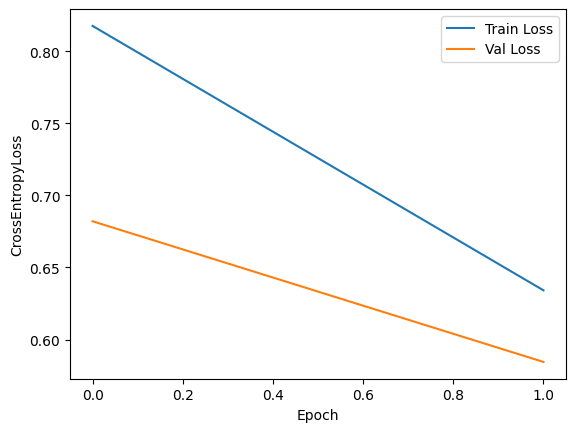

In [105]:
EXP_NAME = 'pHLA_predictor'
N_EPOCHS = 2
BATCH_SIZE = 1
PEPTIDE_EMB_DIM = 10 # Can be changed
HLA_FP_DIM = 80 # Fixed
CHECKPOINT_FOLDER = os.path.join('.', 'checkpoints', EXP_NAME)
logname = os.path.join(CHECKPOINT_FOLDER, 'train_log.log')
logging.basicConfig(filename=logname,
                    filemode='a',
                    format='%(asctime)s,%(msecs)d %(name)s %(levelname)s - %(message)s',
                    datefmt='%H:%M:%S',
                    level=logging.DEBUG)
LOGGER = logging.getLogger(EXP_NAME)

os.makedirs(CHECKPOINT_FOLDER, exist_ok=True)
pep_padding_idx = seq_tokenizer.padding_idx

# Make data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=2, shuffle=True)
val_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)

# Create model
model = pHLAPredictor(p_emb_dim=PEPTIDE_EMB_DIM, hla_fp_dim=HLA_FP_DIM, padding_idx_seq=pep_padding_idx)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print(model)
LOGGER.info(model)

out_metrics = train(model, train_loader, val_loader, optimizer, criterion, N_EPOCHS, DEVICE, checkpoint_path=CHECKPOINT_FOLDER, logger=LOGGER)

train_losses, train_acc, train_precision, train_recall, train_prob_neg, train_prob_pos, val_losses, val_acc, val_precision, val_recall, val_prob_neg, val_prob_pos = out_metrics

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('CrossEntropyLoss')
plt.legend()
plt.savefig(os.path.join(CHECKPOINT_FOLDER, 'loss.png'))
plt.show()

with open(os.path.join(CHECKPOINT_FOLDER, 'train_val_metrics.csv'), 'w') as f:
    f.write('train_loss,val_loss,train_acc,val_acc,train_precision,val_precision,train_recall,val_recall,train_prob_neg,val_prob_neg,train_prob_pos,val_prob_pos\n')
    for train_loss, val_loss in zip(train_losses, val_losses):
        f.write(f'{train_loss},{val_loss},{train_acc},{val_acc},{train_precision},{val_precision},{train_recall},{val_recall}\n')